# MNIST data using keras CNN and ANN

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Lets have a look at the data

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can start by splitting our train data into inputs at outputs and visualising the amount of data we have in the set

<BarContainer object of 10 artists>

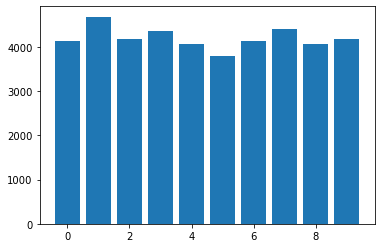

In [16]:
Y_train = train["label"]
X_train = train.drop("label" , axis=1)

plt.bar(Y_train.value_counts().index, Y_train.value_counts().values)

We have a pretty even amount of data between all the categories. Now lets check for null values

In [21]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [22]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

No null values. Now lets normalise all of our data so instead of [0,255] it is [0,1]. This allows the CNN to converge faster and reduces the effect of illumination's differences.

In [23]:
X_train = X_train/255
test = test/255

Currently the data is in the form of a single row with 784 entries each with a pixel value. Instead lets convert the data into 28x28x1 matrices for each image. Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel, hence the dimension of 1.

In [27]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]) as that is how the CNN will output the results.

In [36]:
Y_train = tf.keras.utils.to_categorical(Y_train)

Now lets take a look at one of the images in the dataset to see what we are working with.

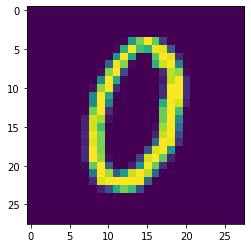

In [45]:
plt.imshow(X_train[5])

Finally, lets take a portion of the training set (10%) to be used as validation

In [47]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)

## ANN model

Lets start by using a simple ANN to try and classify the digits.

In [48]:
ANN = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

ANN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Now we can compile our model and define our loss function and optimiser to begin training. We will also implement early stopping to end the training if the validation accuracy begins to get worse.

In [70]:
ANN.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy() , metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights = True)

ANN_history = ANN.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_val, Y_val), verbose=1, callbacks=es)

Epoch 1/50
296/296 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.2060 - val_accuracy: 0.9724
Epoch 2/50
296/296 [==============================] - 1s 2ms/step - loss: 4.5480e-04 - accuracy: 0.9999 - val_loss: 0.1881 - val_accuracy: 0.9726
Epoch 3/50
296/296 [==============================] - 1s 4ms/step - loss: 2.4147e-05 - accuracy: 1.0000 - val_loss: 0.1862 - val_accuracy: 0.9731
Epoch 4/50
296/296 [==============================] - 1s 5ms/step - loss: 1.2330e-05 - accuracy: 1.0000 - val_loss: 0.1865 - val_accuracy: 0.9729
Epoch 5/50
296/296 [==============================] - 2s 5ms/step - loss: 9.8843e-06 - accuracy: 1.0000 - val_loss: 0.1871 - val_accuracy: 0.9733
Epoch 6/50
296/296 [==============================] - 2s 5ms/step - loss: 8.4297e-06 - accuracy: 1.0000 - val_loss: 0.1869 - val_accuracy: 0.9738
Epoch 7/50
296/296 [==============================] - 2s 5ms/step - loss: 7.4131e-06 - accuracy: 1.0000 - val_loss: 0.1867 - val

In [72]:
loss_ANN, acc_ANN = ANN.evaluate(X_val, Y_val, verbose = 0)
print(f"Loss: {loss_ANN}, Accuracy: {acc_ANN}")

Loss: 0.1862352192401886, Accuracy: 0.9730952382087708


The accuracy here is pretty good, but this can be improved much further using CNNs.

# CNN model

The architecture we want for our CNN is as follows:

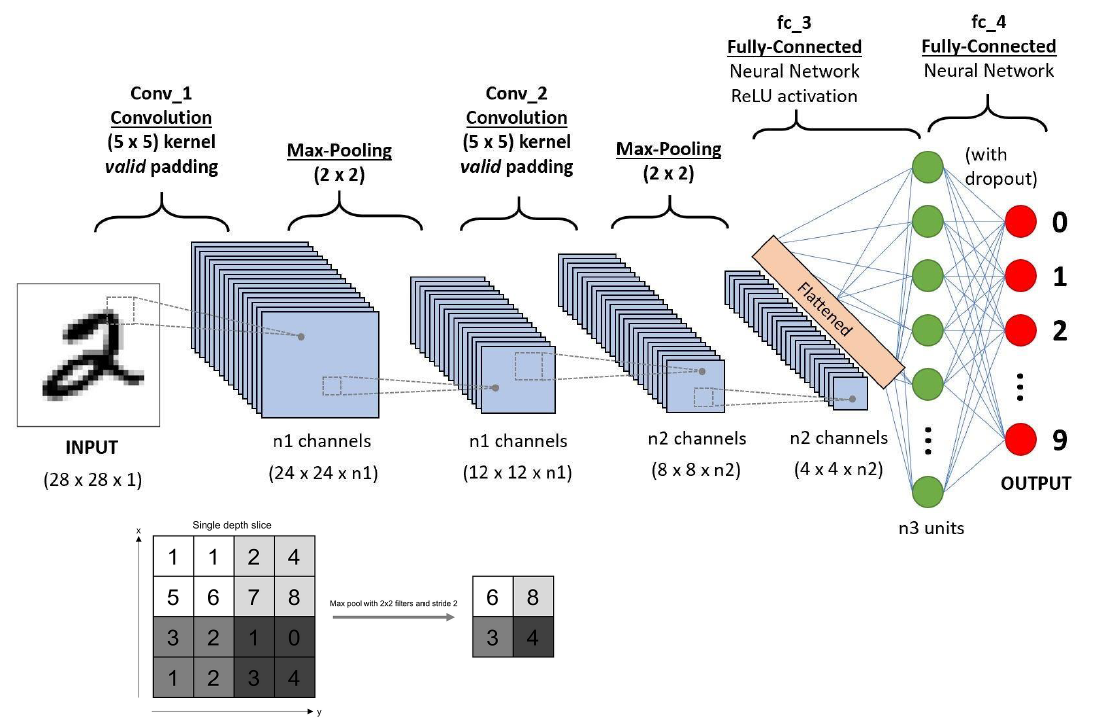

In [97]:
CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 5, activation="relu", input_shape=(28,28,1)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 5, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 64)          36928     
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 64)         

As done previously, lets define an optimiser and compile our model with an early stopper.

In [98]:
CNN.compile(optimizer="adam", loss="categorical_crossentropy" , metrics=["accuracy"])
es1 = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5, restore_best_weights = True)

Another thing we can do is augment our dataset by making small modifications to random datapoints and adding them to the set. For example, we can rotate the images, translate them, mirror etc.

In [92]:
gendata = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

Now we can train the model

In [99]:
CNN_history = CNN.fit(gendata.flow(X_train,Y_train, batch_size=86),
                              epochs = 30, validation_data = (X_val,Y_val),
                              verbose = 1, callbacks=[es1])

Epoch 1/30
440/440 [==============================] - 37s 80ms/step - loss: 0.7853 - accuracy: 0.7394 - val_loss: 0.1104 - val_accuracy: 0.9655
Epoch 2/30
440/440 [==============================] - 36s 82ms/step - loss: 0.2314 - accuracy: 0.9348 - val_loss: 0.0896 - val_accuracy: 0.9752
Epoch 3/30
440/440 [==============================] - 37s 84ms/step - loss: 0.1589 - accuracy: 0.9566 - val_loss: 0.0547 - val_accuracy: 0.9855
Epoch 4/30
440/440 [==============================] - 37s 84ms/step - loss: 0.1277 - accuracy: 0.9660 - val_loss: 0.0475 - val_accuracy: 0.9857
Epoch 5/30
440/440 [==============================] - 39s 90ms/step - loss: 0.1097 - accuracy: 0.9710 - val_loss: 0.0546 - val_accuracy: 0.9843
Epoch 6/30
440/440 [==============================] - 38s 87ms/step - loss: 0.0951 - accuracy: 0.9750 - val_loss: 0.0399 - val_accuracy: 0.9905
Epoch 7/30
440/440 [==============================] - 39s 90ms/step - loss: 0.0883 - accuracy: 0.9758 - val_loss: 0.0346 - val_accuracy:

Now that the training is complete, we can visualise the results of the epochs

Loss: 0.021995458751916885, Accuracy: 0.994523823261261


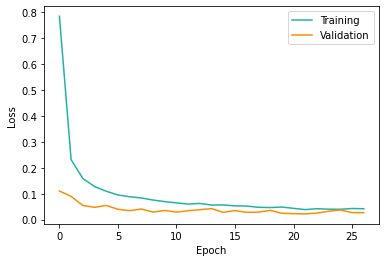

In [103]:
loss_CNN, acc_CNN = CNN.evaluate(X_val, Y_val, verbose = 0)
print(f"Loss: {loss_CNN}, Accuracy: {acc_CNN}")
plt.plot(CNN_history.history["loss"], label="Training", color="lightseagreen")
plt.plot(CNN_history.history["val_loss"], label="Validation", color="darkorange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Finally we can display a confusion matrix so we can see how the model is classifiying the digits.

132/132 [==============================] - 1s 8ms/step


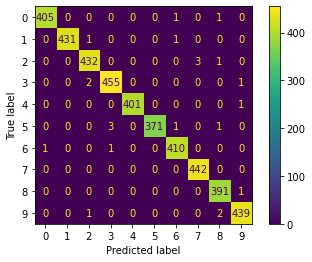

In [111]:
Y_pred = CNN.predict(X_val)
cm = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(Y_pred, axis=1))
ConfusionMatrixDisplay(cm).plot()

Finally lets use the supplied test data to generate our submission

In [114]:
predictions = np.argmax(CNN.predict(test), axis=1)

875/875 [==============================] - 9s 10ms/step


In [128]:
Id = [x for x in range(1,len(predictions)+1)]
sub_df = pd.DataFrame({"ImageId":Id, "Label":predictions})
sub_df.to_csv("Submission.csv",  index=False)

In [129]:
CNN.save("CNN_digit_recogniser_model")

INFO:tensorflow:Assets written to: CNN_digit_recogniser_model\assets


INFO:tensorflow:Assets written to: CNN_digit_recogniser_model\assets
